# TMDLs DATA EXPLORATION
<i> Ryan Treves

Under the Clean Water Act (CWA) section 303(d), states and Tribes are required to monitor water bodies in their territory, and identify water bodies for which a water quality standard has not been met. To do this, they must conduct 'assessments' of water bodies based on whether that water body attains its water quality standard for a certain type of use (e.g., swimming, fishing). Water bodies are delineated into 'assessment units' for the purposes of organizing assessments. Based on the results of the assessment, an assessment unit is assigned an Integrated Reporting (IR) category from 1-5 based on the degree of impairment of the water body. An IR category 5 determination means that a TMDL should be developed for that assessment unit, and the water is 'impaired'. (See https://drive.google.com/drive/u/0/folders/1tGpCSD-3mRBChTC1PZStt5bdRljTK1ck for more details on IR category determination).
 Every two years (reporting cycles are biennial), states must submit their list of impaired waters (including but not limited to all waters with an IR category 5 determination) as a part of their Integrated Report (IR) to the federal EPA under  sections 303(d), 305(b), and 314.

See https://www.epa.gov/wqs-tech/supplemental-module-listing-impaired-waters-and-developing-tmdls#tab-2  for more details.

### Questions:
- How many Assessment Units (AUs) exist nationwide?
- For many AUs do we have a HUC code match?
- How many use assessments nationwide, ever, have contributed to an IR5 category determination?
- How many unique assessment units have been assigned category IR5?
- Which states have had the most use assessments leading to IR5 determinations?
- Which states have had the highest rate of IR5 determinations per assessment unit?
- For what fraction of use assessments do we have an assessment date?
- What parameters have caused the most use non-attainment declarations?
- What parameters have caused the most assessment units to be categorized as IR5, irrespective of number of use non-attainment declarations?
- What uses have the highest rate of non-attainment?

Note: the dataset of AUs doesn't include Pennsylvania (see `ATTAINS_data_cleaning.ipynb` for an explanation)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
from urllib.request import urlopen
import datetime as dt
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')
pd.options.display.max_columns = 200
pd.options.display.max_rows = 2000
# display all rows & columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Load in ATTAINS data
# Assessment Units (source: `ATTAINS_data_cleaning.ipynb`)
AUs = pd.read_csv('Clean_AU_data/all_AUs_cleaned.csv')
# Assessments (source: `pull_NotSupporting_assessments.R`)
assessments = pd.read_csv('all_NotSupporting_assessments.csv', dtype={'reportingCycleText': str}, parse_dates=['assessment_date'], date_parser=lambda t: pd.to_datetime(t, errors='coerce'))
# TMDL Actions (source: `pull_actions.R`)
all_actions = pd.read_csv('all_actions.csv', parse_dates=['completionDate', 'TMDLDate'], date_parser=lambda t: pd.to_datetime(t, errors='coerce')).drop('Unnamed: 0', axis=1).drop_duplicates()
all_actions_permit_data = pd.read_csv('all_actions_permit_data.csv').drop('Unnamed: 0', axis=1).drop_duplicates()

# RAD Data
# HUC AUID link table (source: `get_huc_AUID_links.R`)
HUC_AUID_links = pd.read_csv('huc_AUID_links.csv', dtype={'attributes.huc12': object})
HUC_AUID_links = HUC_AUID_links.drop('Unnamed: 0', axis=1).rename(columns={'attributes.huc12': 'HUC-12', 'attributes.assessmentunitidentifier':'AUID'})
# HUC NPDES permit link table (source: `get_huc_npdes_permit_links.R`)
HUC_npdes_permit_links = pd.read_csv('huc_npdes_permit_links.csv', dtype={'attributes.WBD_HUC12': object})
HUC_npdes_permit_links = HUC_npdes_permit_links.drop('Unnamed: 0', axis=1).rename(columns={'attributes.WBD_HUC12': 'HUC-12'})

# 1.  Assessment Units

In [29]:
AUs.head()

,Unnamed: 0.1,Unnamed: 0,AUID,items.organizationIdentifier,items.organizationName,items.assessmentUnits.assessmentUnitIdentifier,items.assessmentUnits.assessmentUnitName,items.assessmentUnits.agencyCode,items.assessmentUnits.statusIndicator,items.assessmentUnits.useClass,items.assessmentUnits.waterTypes.waterTypeCode,items.assessmentUnits.waterTypes.waterSizeNumber,items.assessmentUnits.waterTypes.unitsCode,HUC-8,items.organizationTypeText,HUC-12,count,items.assessmentUnits.locationDescriptionText,items.assessmentUnits.stateCode,items.assessmentUnits.waterTypes.sizeEstimationMethodCode,items.assessmentUnits.waterTypes.sizeSourceText,items.assessmentUnits.waterTypes.sizeSourceScaleText,items.assessmentUnits.monitoringStations.monitoringOrganizationIdentifier,items.assessmentUnits.monitoringStations.monitoringLocationIdentifier,items.assessmentUnits.monitoringStations.monitoringDataLinkText,items.assessmentUnits.locations.locationTypeCode,items.assessmentUnits.locations.locationText,HUC-10
0,0,0,WYGR140401040103_01,Wyoming,State,Lower Big Sandy River,From the confluence with Squaw Creek downstrea...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,2.1,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,WYNP101800020105_02,Wyoming,State,Muddy Creek,Entire watershed upstream of the confluence wi...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,44.5,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,WYBH100800140107_01,Wyoming,State,Dry Gulch,From the confluence with the Shoshone River to...,WY,"{\useClassCode\"":\""117\""","\""useClassName\"":\""CLASS 3B\""}""",STREAM,0.5,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,WYBH100800030108_02,Wyoming,State,Little Popo Agie River,From the confluence with the Popo Agie River u...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,11.1,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,WYGR140401040303 _01,Wyoming,State,Pacific Creek,Confluence with Jack Morrow Creek upstream to ...,WY,"{\useClassCode\"":\""85\""","\""useClassName\"":\""CLASS 2AB\""}""",STREAM,13.8,Miles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### How many Assessment Units (AUs) have ever existed nationwide?
Note: this estimate doesn't include Pennsylvania, which according to https://attains.epa.gov/attains-public/api/assessmentUnits?stateCode=PA&returnCountOnly=Y contains on the order of 200,000 AUs on its own.

In [30]:
len(AUs['AUID'].unique())

331553

### For many AUs do we have a HUC code match?

In [31]:
AUs[(~pd.isna(AUs['HUC-12'])) | (~pd.isna(AUs['HUC-10'])) | (~pd.isna(AUs['HUC-8']))].shape[0]

99534

### Does a single water body ever have more than one AUID on record?

In [32]:
counts = AUs.groupby(['items.assessmentUnits.assessmentUnitName', 'items.assessmentUnits.assessmentUnitIdentifier'], as_index=False).nunique()
changed_AUIDs = counts[counts['AUID']>1][['items.assessmentUnits.assessmentUnitName', 'items.assessmentUnits.assessmentUnitIdentifier']]

In [33]:
changed_AUIDs = changed_AUIDs.merge(AUs[['AUID', 'HUC-12', 'items.assessmentUnits.assessmentUnitName', 'items.assessmentUnits.assessmentUnitIdentifier']], on=['items.assessmentUnits.assessmentUnitName', 'items.assessmentUnits.assessmentUnitIdentifier'], how='left').drop_duplicates()
changed_AUIDs.head(20)

,items.assessmentUnits.assessmentUnitName,items.assessmentUnits.assessmentUnitIdentifier,AUID,HUC-12
0,Aarons Creek from the confluence with Big Bran...,Aarons Creek,VAC-L73R_AAR01A00,NaN
2,Aarons Creek from the confluence with Big Bran...,Aarons Creek,VAW-L73R_AAR01A00,NaN
3,Abenaki,ABENAKI,VT14-03L03_02,NaN
4,Abenaki,ABENAKI,VT14-03L03_01,NaN
5,All waters in watershed L33R,Unsegmented Portion of Watershed L33,VAC-L33R_ZZZ01A00,NaN
7,All waters in watershed L33R,Unsegmented Portion of Watershed L33,VAW-L33R_ZZZ01A00,NaN
8,Allen Creek from its headwaters to its mouth o...,Allen Creek,VAW-L67R_ALL01A08,NaN
9,Allen Creek from its headwaters to its mouth o...,Allen Creek,VAC-L67R_ALL01A08,NaN
11,Amherst,AMHERST,VT10-15L02_01,NaN
12,Amherst,AMHERST,VT10-15L02_02,NaN


Cross-referencing these records with the assessments file below, it appears that many of the examples in the table above represent water bodies in Virginia that underwent a AUID change in 2018 from using the 'VAC' prefix to using 'VAP' or 'VAW' (maybe this has to do with a change to the state's segmentation methodology?). Similar renamings may have occurred in CT, RI, MD, and MO.
Other examples seem to be distinct water bodies that happen to share the same `items.assessmentUnits.assessmentUnitName` and `items.assessmentUnits.assessmentUnitIdentifier` values - in some cases, because they are unnamed tributaries or unsegmented portions of watersheds, in other cases, because names are not specific. This appears to be the case for the examples from Alabama.
Some examples from Vermont use a two-digit 'Assessment Database segment code' suffix for "EPA tracking purposes" (e.g., VT17-01L01_01 and VT17-01L01_02, see https://www.epa.gov/sites/default/files/2019-02/documents/2018-vt-303d-list-report.pdf)

# 2. Assessments

In [34]:
assessments.head()

,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,assessmentUnitIdentifier,useName,useAttainmentCode,epaIRCategory,associatedActionIdentifier,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
0,1,AL,21AWIC,State,2004,AL-Gulf of Mexico,Contact Recreation,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaT
1,2,AL,21AWIC,State,2004,AL-Gulf of Mexico,Contact Recreation,N,NaN,NaN,N,Cause,METALS,2004.0,2002,NaN,NaT
2,3,AL,21AWIC,State,2004,AL-Gulf of Mexico,Fishing,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaT
3,4,AL,21AWIC,State,2004,AL-Gulf of Mexico,Fishing,N,NaN,NaN,N,Cause,METALS,2004.0,2002,NaN,NaT
4,5,AL,21AWIC,State,2004,AL-Gulf of Mexico,Propagation of Fish and Wildlife,N,NaN,NaN,N,Cause,MERCURY,2004.0,2002,NaN,NaT


In [35]:
len(assessments)

3960114

### How many use assessments nationwide, ever, have contributed to a 'Not Supporting' determination?
From here on, 'impaired' = received a 'Not Supporting' determination for any use. One assessment unit can be impaired by having multiple impairments - e.g., multiple chemicals (parameters) or multiple uses or both.
Here, a use assessment is uniquely identified by assessmentUnitIdentifier + useName + parameterName + reportingCycleText + assessment_date

In [36]:
assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'parameterName', 'assessment_date']).shape[0]

3699477

These numbers are different because the assessments table contains one row per use assessment x TMDL instance, and some use assessments are associated with multiple TMDLs from different years.

### What proportion of assessments have been associated with multiple TMDLs?

In [37]:
assessments.duplicated(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText', 'parameterName', 'assessment_date']).value_counts(normalize=True)

False    0.934184
True     0.065816
dtype: float64

### What proportion of all assessment units have been associated with multiple TMDLs?

In [38]:
len(assessments[assessments.duplicated(subset=['assessmentUnitIdentifier', 'associatedActionIdentifier'])].dropna(subset='associatedActionIdentifier').drop_duplicates('assessmentUnitIdentifier'))/len(AUs['AUID'].unique())

0.24237452232373105

### How many unique assessment units have been impaired?

In [39]:
len(assessments['assessmentUnitIdentifier'].unique())

220326

### Which states have had the most use assessments leading to impairments?

In [40]:
assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'reportingCycleText',  'parameterName', 'assessment_date'])[['state_code']].value_counts(normalize=True)

state_code
PA            0.150262
NH            0.136518
KS            0.086511
CA            0.060322
VA            0.058579
FL            0.050741
NJ            0.044158
OR            0.038471
WV            0.033967
NV            0.027243
IN            0.023406
MI            0.022562
WA            0.020319
MT            0.017350
NC            0.016956
MN            0.016645
ID            0.015851
OH            0.015627
MA            0.013891
TN            0.013100
IL            0.011953
TX            0.010832
OK            0.010769
WI            0.010639
KY            0.010069
AR            0.008470
LA            0.005192
SC            0.005006
PR            0.004974
CT            0.004763
VT            0.004592
GA            0.004165
AL            0.004144
SD            0.004061
IA            0.003507
CO            0.003328
HI            0.003304
NM            0.003031
MO            0.002970
NE            0.002884
RI            0.002796
DE            0.002290
MS            0.002075


### Which states have the highest and lowest rates of impairments per assessment unit?

In [41]:
# Get counts of assessment units in each state
AU_counts = {}
for state in assessments['state_code'].unique():
    response = urlopen('https://attains.epa.gov/attains-public/api/assessmentUnits?stateCode=' + state + '&returnCountOnly=Y')
    data = json.loads(response.read())['count']
    AU_counts[state] = data

In [42]:
rates = pd.DataFrame(assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName',  'parameterName', 'reportingCycleText', 'assessment_date'])['state_code'].value_counts())
rates = rates.reset_index().rename(columns = {'index':'state', 'state_code':'# impairments'})
rates['AUs'] = rates['state'].apply(lambda x: AU_counts[x])
rates['Impairment rate'] = rates['# impairments']/rates['AUs']

In [43]:
rates.sort_values(by='Impairment rate', ascending=False).head(10)

,state,# impairments,AUs,Impairment rate
6,NJ,163360,958,170.521921
9,NV,100786,711,141.752461
2,KS,320045,2421,132.195374
3,CA,223161,4068,54.857670
13,MT,64186,1203,53.354946
28,PR,18403,358,51.405028
33,SD,15022,400,37.555000
26,LA,19206,563,34.113677
17,OH,57812,1723,33.553105
5,FL,187714,7072,26.543269


In [44]:
rates.sort_values(by='Impairment rate', ascending=False).tail(10)

,state,# impairments,AUs,Impairment rate
45,ME,6989,1967,3.553127
34,IA,12973,4924,2.634647
0,PA,555891,216735,2.564842
38,MO,10988,4331,2.537058
39,NE,10671,4270,2.499063
8,WV,125659,60450,2.078726
49,ND,2294,1834,1.250818
23,WI,39357,35583,1.106062
15,MN,61579,55855,1.102480
51,NY,1548,4873,0.317669


Note: this table counts an impairment as a unique combination of a parameter x use x AUID x reportingCycle. Thus, having one parameter lead to 5 uses being impaired will have the same effect on impairment rate as 5 parameters each leading to one use being impaired.

### For what fraction of use assessments do we have an assessment date?

In [45]:
use_assessments_unique = assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'useName', 'parameterName', 'reportingCycleText', 'assessment_date'])
use_assessments_unique[~pd.isna(use_assessments_unique['assessment_date'])].shape[0]/use_assessments_unique.shape[0]

0.24951797240528864

### What parameters have caused the most impairments?

In [46]:
use_assessments_unique[use_assessments_unique['parameterStatusName']=='Cause']['parameterName'].value_counts(normalize=True).iloc[0:10]

ESCHERICHIA COLI (E. COLI)          0.066455
PATHOGENS                           0.065500
SILTATION                           0.060735
FECAL COLIFORM                      0.051016
DISSOLVED OXYGEN                    0.046293
PH                                  0.042407
MERCURY                             0.041189
MERCURY IN FISH TISSUE              0.036908
PCBS IN FISH TISSUE                 0.030882
POLYCHLORINATED BIPHENYLS (PCBS)    0.026713
Name: parameterName, dtype: float64

### What parameters have caused the most assessment units to be impaired, irrespective of number of use non-attainment declarations?

In [47]:
culprits_unique = assessments.drop_duplicates(subset=['assessmentUnitIdentifier', 'reportingCycleText', 'assessment_date', 'parameterName'])

culprits_unique[culprits_unique['parameterStatusName']=='Cause']['parameterName'].value_counts(normalize=True).iloc[0:10]

PATHOGENS                           0.074285
SILTATION                           0.072638
ESCHERICHIA COLI (E. COLI)          0.068849
MERCURY                             0.052655
MERCURY IN FISH TISSUE              0.046431
FECAL COLIFORM                      0.042380
PH                                  0.040274
DISSOLVED OXYGEN                    0.038449
METALS                              0.034789
POLYCHLORINATED BIPHENYLS (PCBS)    0.027160
Name: parameterName, dtype: float64

### What uses have the highest rate of non-attainment?

In [48]:
use_assessments_unique['useName'].value_counts(normalize=True).iloc[0:10]

Fish Consumption              0.145012
Aquatic Life                  0.063840
Primary Contact Recreation    0.044730
Water Contact Sports          0.043442
Recreation                    0.038429
AQUATIC LIFE USE              0.036220
Warm Water Fishes             0.031540
Cold Water Fishes             0.028787
Domestic Water Supply         0.025068
Aquatic Life Integrity        0.022380
Name: useName, dtype: float64

Let's look at an example of one AUID x use x parameter combination over time:

In [49]:
assessments[(assessments['assessmentUnitIdentifier']=='AL03140106-0302-202') &
            (assessments['useName']=='Contact Recreation') &
            (assessments['parameterName']=='AMMONIA, TOTAL')].sort_values(by='reportingCycleText').drop_duplicates()

,Unnamed: 0,state_code,organizationIdentifier,organizationTypeText,reportingCycleText,assessmentUnitIdentifier,useName,useAttainmentCode,epaIRCategory,associatedActionIdentifier,threatenedIndicator,parameterStatusName,parameterName,cycle_first_listed,cycleLastAssessedText,cycle_scheduled_for_TMDL,assessment_date
1694,1695,AL,21AWIC,State,2006,AL03140106-0302-202,Contact Recreation,N,NaN,NaN,N,Cause,"AMMONIA, TOTAL",2006.0,2006,NaN,2006-04-01
3225,3226,AL,21AWIC,State,2008,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",2006.0,2008,2010.0,2006-04-01
4861,4862,AL,21AWIC,State,2010,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2015.0,2006-04-01
6506,6507,AL,21AWIC,State,2012,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2015.0,2006-04-01
8143,8144,AL,21AWIC,State,2014,AL03140106-0302-202,Contact Recreation,N,5,NaN,N,Cause,"AMMONIA, TOTAL",1998.0,2006,2016.0,2006-04-01


Clearly, the fields `cycle_first_listed` and `cycleLastAssessedText` are misleading.

### Which states have the most and fewest reporting cycles present in ATTAINS?

In [50]:
state_reporting_cycles = assessments.groupby('state_code').nunique()[['reportingCycleText']].sort_values('reportingCycleText', ascending=False)

state_reporting_cycles.head(15)

,reportingCycleText
state_code,
LA,11
NM,11
VI,11
VA,11
MS,11
CT,11
TX,11
OK,11
TN,11


In [51]:
state_reporting_cycles.tail(10)

,reportingCycleText
state_code,
OH,8
IL,8
WI,7
AR,6
MD,5
FL,4
PA,4
OR,3
WA,2


### What is the distribution of times when an AUID first appears on a 303(d) list in ATTAINS?

In [52]:
# Determine first appearance on a 303(d) list in ATTAINS
# appearance_dates = assessments.groupby(['assessmentUnitIdentifier', 'parameterName'], as_index=False).min()[
#         ['assessmentUnitIdentifier', 'parameterName', 'reportingCycleText']]
# appearance_dates.rename(columns={'reportingCycleText': 'appearance_date'},
#                                inplace=True)
# appearance_dates['appearance_date'] = pd.to_datetime(appearance_dates['appearance_date'])

In [53]:
# test = assessments.merge(appearance_dates, on=['assessmentUnitIdentifier', 'parameterName'], how='inner')
# test.head()

TODO: change `appearance_date` from january 1st to just the year

# 3. Actions

### How many unique TMDL actions do we have?

In [55]:
len(all_actions.drop_duplicates(subset='actionIdentifier'))

20009

How does this compare to the number of unique actions in our assessments table?

In [56]:
len(assessments.drop_duplicates(subset='associatedActionIdentifier'))

21816

### How many unique AUs are represented in the actions data?

In [57]:
len(all_actions.drop_duplicates(subset='assessmentUnitIdentifier'))

96171

### Which states have the most TMDL actions?

In [58]:
all_actions.drop_duplicates(subset='actionIdentifier')['state_code'].value_counts(normalize=True).iloc[0:10]

WV    0.268479
KS    0.101804
VA    0.088460
MD    0.042031
MT    0.028787
DE    0.028237
CO    0.022990
OK    0.021290
FL    0.020241
CA    0.019791
Name: state_code, dtype: float64

### Which states have the highest and lowest rates of TMDL actions per AUID?

In [59]:
TMDL_rates = pd.DataFrame(all_actions.drop_duplicates(
    subset=['actionIdentifier'])['state_code'].value_counts())
TMDL_rates = TMDL_rates.reset_index().rename(columns={'index': 'state', 'state_code': '# TMDLs'})
TMDL_rates = TMDL_rates[TMDL_rates['state'] != 'GU']
TMDL_rates['AUs'] = TMDL_rates['state'].apply(lambda x: AU_counts[x])
TMDL_rates['TMDL rate'] = TMDL_rates['# TMDLs'] / TMDL_rates['AUs']
TMDL_rates.sort_values(by='TMDL rate', ascending=False).head(10)

,state,# TMDLs,AUs,TMDL rate
5,DE,565,590,0.957627
13,SD,369,400,0.922500
3,MD,841,973,0.864337
1,KS,2037,2421,0.841388
11,LA,395,563,0.701599
24,WY,183,314,0.582803
4,MT,576,1203,0.478803
12,MS,374,1178,0.317487
18,NJ,304,958,0.317328
6,CO,460,1893,0.243001


In [60]:
TMDL_rates.sort_values(by='TMDL rate', ascending=False).tail(10)

,state,# TMDLs,AUs,TMDL rate
37,MI,115,8028,0.014325
46,KY,52,6239,0.008335
15,MN,344,55855,0.006159
21,NH,200,32484,0.006157
35,WA,121,20272,0.005969
41,IN,94,16762,0.005608
43,NC,75,13628,0.005503
42,WI,83,35583,0.002333
14,PA,367,216735,0.001693
51,OR,5,7316,0.000683


### What is the temporal distribution of TMDLs?

Based on a document here: https://www.exchangenetwork.net/schema/ATTAINS/1/ATTAINS_DET_v1.0a.xlsx , `completionDate` refers to the planned TMDL date, and `TMDLDate` refers to the actual date the TMDL was approved by EPA.

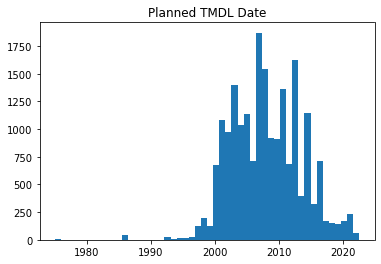

In [61]:
plt.title('Planned TMDL Date')
plt.hist(all_actions.drop_duplicates(subset='actionIdentifier')['completionDate'], bins=50);

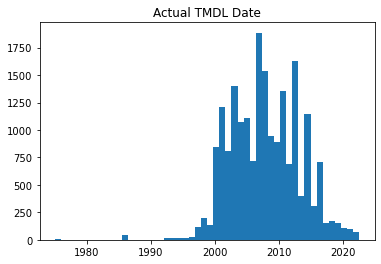

In [62]:
plt.title('Actual TMDL Date')
plt.hist(all_actions.drop_duplicates(subset='actionIdentifier')['TMDLDate'], bins=50);

Text(0.5, 0, 'Days')

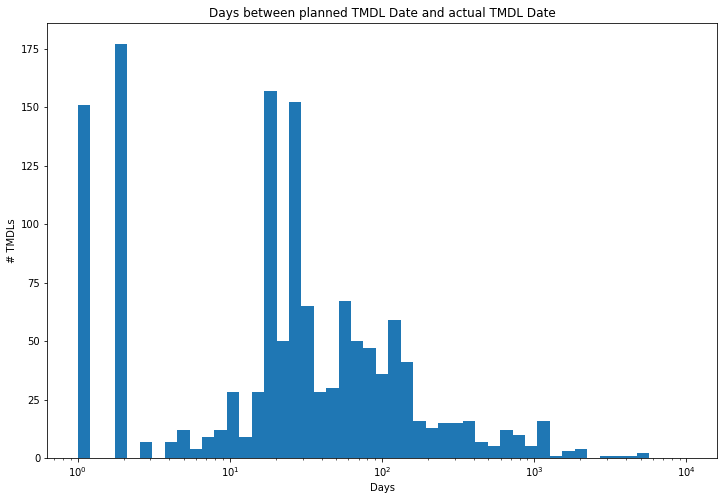

In [63]:
import numpy as np
delays = (all_actions.drop_duplicates(subset='actionIdentifier')['TMDLDate'] -
          all_actions.drop_duplicates(subset='actionIdentifier')['completionDate']) / dt.timedelta(
    days=1)
plt.figure(figsize=(12, 8))
plt.xscale("log")
plt.hist(delays, bins=np.logspace(np.log10(1),np.log10(10000.0), 50))
plt.title('Days between planned TMDL Date and actual TMDL Date')
plt.ylabel('# TMDLs')
plt.xlabel('Days')

### Which pollutants most often lead to TMDLs?

In [64]:
all_actions.drop_duplicates(subset=['actionIdentifier', 'pollutantName'])['pollutantName'].value_counts(normalize=True).iloc[0:10]

FECAL COLIFORM                  0.155362
IRON                            0.102766
ESCHERICHIA COLI (E. COLI)      0.070738
PHOSPHORUS, TOTAL               0.059801
SEDIMENT                        0.040726
PH                              0.037441
ALUMINUM                        0.036657
NITROGEN, TOTAL                 0.030498
TOTAL SUSPENDED SOLIDS (TSS)    0.027586
MANGANESE                       0.027474
Name: pollutantName, dtype: float64

### Which combinations of state x pollutant are most frequent across all TMDLS?

In [65]:
pd.DataFrame(all_actions.drop_duplicates(subset=['actionIdentifier', 'pollutantName'])[['pollutantName', 'state_code']].value_counts(normalize=True).iloc[0:10])

0
pollutantName              state_code          
IRON                       WV          0.085558
FECAL COLIFORM             WV          0.050021
ALUMINUM                   WV          0.022061
PH                         WV          0.019411
ESCHERICHIA COLI (E. COLI) VA          0.017545
FECAL COLIFORM             VA          0.015902
                           KS          0.015454
MANGANESE                  WV          0.015118
DISSOLVED OXYGEN           KS          0.009705
SEDIMENT                   MT          0.009482

### For how many TMDL actions do we have one or more NPDES permit ID matches?

In [66]:
all_actions_permit_data.dropna().drop_duplicates('actionIdentifier').shape[0]

4069

### What is the distribution of these TMDLs across states?

In [67]:
all_actions_permit_data.dropna().drop_duplicates('actionIdentifier')['NPDESIdentifier'].apply(lambda x: x[0:2]).value_counts(normalize=True)

KS    0.167363
WV    0.109118
VA    0.060211
MS    0.046695
CA    0.041042
LA    0.039076
MN    0.036864
TX    0.036127
MD    0.033669
SD    0.032686
TN    0.028017
OK    0.026296
WY    0.023347
FL    0.022856
MO    0.022364
MT    0.021873
NE    0.021873
GA    0.018678
IL    0.017941
SC    0.016220
AL    0.014500
MI    0.012042
NM    0.011059
DE    0.010322
IA    0.010076
NC    0.009830
IN    0.009339
AR    0.009093
MA    0.007864
ID    0.007619
KY    0.007127
UT    0.006881
NJ    0.006636
AK    0.006636
RI    0.005898
CO    0.005652
N/    0.004424
ND    0.003686
PR    0.003195
CT    0.003195
NH    0.002703
AZ    0.002458
ME    0.001966
VT    0.001966
M-    0.001720
WA    0.001229
11    0.000983
HI    0.000983
No    0.000737
VI    0.000737
no    0.000737
OH    0.000737
OR    0.000492
WG    0.000492
GU    0.000492
2P    0.000492
00    0.000246
15    0.000246
S-    0.000246
 W    0.000246
IM    0.000246
#     0.000246
PA    0.000246
H1    0.000246
2I    0.000246
MG    0.000246
co    0.00

### What is the time delay between a water body appearing on the 303(d) list and receiving a TMDL?
Let's try to answer this question for a few states first before looking at the whole country.

In [ ]:
# These states were selected based on having a high number of unique reporting cycles present in their assessments table
states = ['NM', 'VA', 'MS', 'CT']
for state in states:
    state_actions = all_actions[(all_actions['state_code'] == state) & (all_actions['TMDLDate']>=pd.to_datetime('2003-01-01'))].dropna(subset=['assessmentUnitIdentifier', 'pollutantName'])
    state_assessments = assessments[assessments['state_code'] == state].dropna(
        subset=['assessmentUnitIdentifier', 'parameterName'])

    # Data cleaning to account for changes in parameter categorization over time
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(lambda x: x.replace('SULFATES', 'SULFATE'))
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(
        lambda x: x.replace('TEMPERATURE, WATER', 'TEMPERATURE'))
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(
        lambda x: x.replace('ESCHERICHIA COLI (E. COLI)', 'PATHOGENS'))
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(
        lambda x: x.replace('FECAL COLIFORM', 'PATHOGENS'))
    state_assessments['parameterName'] = state_assessments['parameterName'].apply(
        lambda x: x.replace('ENTEROCOCCUS BACTERIA', 'ENTEROCOCCUS'))
    state_actions['pollutantName'] = state_actions['pollutantName'].apply(
        lambda x: x.replace('FECAL COLIFORM', 'PATHOGENS'))
    state_actions['pollutantName'] = state_actions['pollutantName'].apply(
        lambda x: x.replace('ESCHERICHIA COLI (E. COLI)', 'PATHOGENS'))

    # Determine first appearance on a 303(d) list in ATTAINS
    appearance_dates = state_assessments.groupby(['assessmentUnitIdentifier', 'parameterName'], as_index=False).min()[
        ['assessmentUnitIdentifier', 'parameterName', 'reportingCycleText']]
    appearance_dates.rename(columns={'reportingCycleText': 'appearance_date', 'parameterName': 'pollutantName'},
                               inplace=True)
    appearance_dates['appearance_date'] = pd.to_datetime(appearance_dates['appearance_date'])

    # Merge on AU and pollutant
    merged = state_actions.merge(appearance_dates, on=['assessmentUnitIdentifier', 'pollutantName'], how='inner')

    # Calculate delay time
    delays = (merged.drop_duplicates(subset=['assessmentUnitIdentifier', 'pollutantName'])['TMDLDate'] - merged.drop_duplicates(subset=['assessmentUnitIdentifier', 'pollutantName'])[
              'appearance_date']) / dt.timedelta(days=365)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.hist(delays, bins=50);
    plt.axvline(x=0, linestyle='--', c='silver')
    plt.ylabel('# of AU x pollutant combinations')
    plt.xlabel('Years')
    plt.title(state + ': Delays between first impairment in ATTAINS and TMDL Date \n (n=' + str(len(delays)) + ' combos, ' + str(len(merged['assessmentUnitIdentifier'].unique())) + ' assessment units (AUs). TMDLs 2003 or later included.)')

TODO: ### How many AUs scheduled to receive a TMDL actually received one?

# 4. Exploring our linkage tables

In [69]:
HUC_AUID_links.head()

,AUID,HUC-12
0,FL1137A,031300110605
1,FL1145,031300130103
2,FL1146,031200010903
3,FL1146,031200010901
4,FL1151,031300130302


### How many AUIDs do we have in our HUC-AUID link table?

In [70]:
len(HUC_AUID_links.drop_duplicates('AUID'))

419499

### How many of these AUIDs are we able to use to directly merge with our ATTAINS AUID table?

In [71]:
AUs_merged = HUC_AUID_links.drop_duplicates('AUID').merge(AUs, how='inner', on='AUID')
len(AUs_merged[~pd.isna(AUs_merged['HUC-12_x'])])

206349

What explains the AUs that are in the AUs table but not the HUC_AUID_links table?

Based on hand-checking examples from a variety of states, it appears that the primary reasons why AUIDs appear in the AUs table but not the HUC_AUID_links table are:
- Some AUIDs were added in 2022 (e.g., AL06030005-1004-200). These AUIDs would not be present in the HUC_AUID_links table because it is current as of June 2020.
- Some AUIDs were split pre-2020 and are no longer in use (e.g., CAX9013000020021202102208, see https://www.waterboards.ca.gov/sandiego/water_issues/programs/303d_list/ref_reports/miscellaneous_changes_report.shtml). These are still reflected in the AUs table because it goes back to 2002.

What explains the AUs that are in the HUC_AUID_links table but not the AUs table?

Again, based on hand-checking examples, it appears that almost all (if not all) of the AUIDs that appear in the HUC_AUID_links table but not the AUs table are from Pennsylvania, which was excluded from the AUs table due to computation limitations.

### How many NPDES permit IDs do we have in our HUC-permit linkage table?

In [84]:
HUC_npdes_permit_links.head()

,attributes.SOURCE_FEATUREID,HUC-12,npdes_permit_id
0,AL0000019001,060300020503,AL0000019
1,AL0000019002,060300020904,AL0000019
2,AL0000019003,060300020505,AL0000019
3,AL0000019004,060300020503,AL0000019
4,AL0000019005,060300020503,AL0000019


In [81]:
len(HUC_npdes_permit_links.drop_duplicates('npdes_permit_id'))

761542

How does this compare to the total number of active NPDES permit IDs in ICIS-NPDES?

In [91]:
all_permit_ids = pd.read_csv('all_icis_npdes_permit_ids.csv')
len(all_permit_ids.drop_duplicates('npdes_permit_id'))

823373

They are of similar order of magnitude. The difference is likely due to permits in ICIS-NPDES that were retired/terminated prior to 2016 (the date of our HUC-permit linkage table), and other permits that were created after 2016.

### What proportion of TMDLs on current assessment units can we now link to NPDES permit IDs?

In [108]:
actions_current_AUs = all_actions.merge(AUs_merged[['AUID']], left_on='assessmentUnitIdentifier', right_on='AUID', how='inner')
actions_current_AUs = actions_current_AUs.merge(HUC_AUID_links, on='AUID', how='inner')
len(actions_current_AUs.drop_duplicates(subset='actionIdentifier'))

6983

In [109]:
actions_current_AUs = actions_current_AUs.merge(HUC_npdes_permit_links, on='HUC-12', how='inner')
actions_current_AUs.head(100)

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate,AUID,HUC-12,attributes.SOURCE_FEATUREID,npdes_permit_id
0,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR107777,ALR107777
1,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AAY0,ALR10AAY0
2,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AM01,ALR10AM01
3,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AA85,ALR10AA85
4,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AN53,ALR10AN53
5,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10BBY8,ALR10BBY8
6,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10BDTA,ALR10BDTA
7,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10BCC1,ALR10BCC1
8,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10BCI2,ALR10BCI2
9,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10BCLM,ALR10BCLM


In [111]:
len(actions_current_AUs.drop_duplicates(subset='actionIdentifier'))

6243

In [112]:
len(actions_current_AUs.drop_duplicates(subset='AUID'))

18449

In [113]:
len(actions_current_AUs.drop_duplicates(subset='npdes_permit_id'))

246136

# 5. Putting it all together

###

In [132]:
actions_current_AUs.head()

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate,AUID,HUC-12,attributes.SOURCE_FEATUREID,npdes_permit_id
0,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR107777,ALR107777
1,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AAY0,ALR10AAY0
2,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AM01,ALR10AM01
3,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AA85,ALR10AA85
4,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21,AL03140107-0205-102,031401070205,ALR10AN53,ALR10AN53


In [131]:
all_actions.drop_duplicates('actionIdentifier')[all_actions.drop_duplicates('actionIdentifier')['state_code']=='AL']

,organizationIdentifier,organizationTypeText,state_code,actionIdentifier,actionTypeCode,actionStatusCode,completionDate,assessmentUnitIdentifier,pollutantName,pollutantSourceTypeCode,explicitMarginofSafetyText,implicitMarginofSafetyText,TMDLEndPointText,TMDLDate
0,21AWIC,State,AL,36562,TMDL,EPA Final Action,2009-09-23,AL03160205-0310-702,FECAL COLIFORM,Nonpoint source,1320000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
2,21AWIC,State,AL,36561,TMDL,EPA Final Action,2009-09-23,AL03160205-0202-400,FECAL COLIFORM,Both,2010000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
4,21AWIC,State,AL,36556,TMDL,EPA Final Action,2009-09-23,AL03150202-0202-401,FECAL COLIFORM,Both,7290000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
6,21AWIC,State,AL,36559,TMDL,EPA Final Action,2009-09-23,AL03160205-0202-300,FECAL COLIFORM,Both,1660000000 CFU/DAY,N,JUNE-SEPTEMBER: GEOMETRIC MEAN OF 200 COLONIES...,2009-09-23
8,21AWIC,State,AL,39070,TMDL,EPA Final Action,2010-09-21,AL03140107-0205-102,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21
9,21AWIC,State,AL,AL03160111_0303_102_Nutrients_2018,TMDL,EPA Final Action,2017-12-21,AL03160111-0305-102,"PHOSPHORUS, TOTAL",Both,NaN,NaN,NaN,2018-01-22
15,21AWIC,State,AL,39067,TMDL,EPA Final Action,2010-09-21,AL03140202-0502-102,LEAD,Both,NaN,Y,"DISSOLVED LEAD CONCENTRATION OF 0.789 UG/L, US...",2010-09-21
17,21AWIC,State,AL,39066,TMDL,EPA Final Action,2010-09-21,AL03140201-1001-700,ESCHERICHIA COLI (E. COLI),Nonpoint source,NaN,N,JUNE THROUGH SEPTEMBER: GEOMETRIC MEAN E. COL...,2010-09-21
18,21AWIC,State,AL,39068,TMDL,EPA Final Action,2010-09-21,AL03140107-0103-100,ENTEROCOCCUS BACTERIA,Nonpoint source,NaN,N,"IN COASTAL WATERS, BACTERIA OF THE ENTEROCOCCI...",2010-09-21
19,21AWIC,State,AL,AL03150203-0103-200_Pathogens_2019,TMDL,EPA Final Action,2019-08-13,AL03150203-0103-200,ESCHERICHIA COLI (E. COLI),Nonpoint source,NaN,NaN,NaN,2019-09-09
